<a href="https://colab.research.google.com/github/makuhari-city/rousseau-machine/blob/main/NRM_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v300.json
!pip install japanize-matplotlib

# Results for the NRM Exhibition

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as pl
import requests
import numpy as np
import functools as ft
from datetime import datetime
import pandas as pd
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定


DBURL = 'https://vote.metacity.jp/db'
RPCURL = 'https://vote.metacity.jp/rpc/' 

# Cache Topic Data
we don't want to get the same data over and over again. Also it is smart to be transparent when this results was derived.

In [8]:
# we first get a list of topic ids.
listurl = f'{DBURL}/list/'
response = requests.get(listurl).json()
ids = [r['id'] for r in response]

# then we get the topics_info
def gettopicinfo(id):
  url = f'{DBURL}/topic/{id}/'
  return requests.get(url).json()
topics = [gettopicinfo(id) for id in ids]

# we zip this for convienince
now = datetime.now()
topic_data = dict(zip(ids, topics))

print(f'results are based on data stored at {now}')

results are based on data stored at 2021-09-10 20:09:08.732766


In [9]:
# we want a shallow look-up for policies
import json
policy_lookup = []
for topic in topic_data.values():
  items = topic['policies'].items();
  policy_ids = [i[0] for i in items]
  policy = [json.loads(i[1])['title'] for i in items]
  policy_lookup += zip(policy_ids, policy)

policy_lookup = dict(policy_lookup)
print(policy_lookup)


{'808b4b23-3f2e-4c13-859b-d58a0593bbcf': '啓蒙活動重視型', 'b2c461a2-2eaf-411b-b727-1e4168972477': '開発重視型', 'e6b232be-4469-4104-94e5-a3a94bdb439f': '新規性重視型', '10ba62e6-210e-46f1-b251-0258cd68152c': '課題解決やアイデアの具現化を重視', '5dbcd5df-8230-478d-80f4-5b4e7817ff66': '多様性や新たな視点や発想重視', 'fc58ffb1-4f04-4bfc-ac3d-c828ec4c75f4': '物理的な地域住民の声を反映する', '2382e031-6de5-42d4-b902-988457b73e02': '数世代先に向けた眼差しを持つ都市', '9682aad1-519e-4607-b1a3-e3dc466dfdad': 'アーティストのアーティストによるアーティストのための都市', 'a104c312-de19-4274-af31-57933debcc2d': '地域住民のための都市'}


# Total number of participants
We first want to get the total number of participants. We will go through the keys of each 'vote' field.

In [11]:
# among the ids, we want a *clean* list of 'id':'username' relation
# to do that, we first get the 'set' of 'vote.keys'

voter_ids = [list(topic_data[id]['votes'].keys()) for id in ids]

voters_ids_intersect = ft.reduce(lambda x,y: set(x).intersection(set(y)), voter_ids)
voters_ids_union = ft.reduce(lambda x,y: set(x).union(set(y)), voter_ids)

print(f'total voters (intersection):{len(voters_ids_intersect)}')
print(f'total voters (union):{len(voters_ids_union)}')


total voters (intersection):29
total voters (union):43


we see that the total number voters is 29 people. This is number of people that participated in all three problems. If we count the total ids that appeared at least once, we see 43 unique ids. For this report, we use the former to calculate the overall result. 

In [12]:
# for usability we make a dictionary with the usernames
# since we took the intersection of the ids, taking topic is enough to make this lookup

names = [topics[0]['delegates'][id] for id in voters_ids_intersect]
# we also zip,dict this for reusability
voters = dict(zip(voters_ids_intersect, names))

voters = pd.DataFrame(data={'id':voters.keys(),'name':voters.values()})

print(voters)


                                      id              name
0   bf6ec771-1eed-4349-b27c-97280c64d920         Keita Uno
1   29609573-217f-4f67-bca5-ec0fa60cf4f5              momo
2   2be4d6cc-7f35-4395-ae99-d2cc7e0caf37             kntnk
3   9df01e6f-a187-4d12-a6bf-7b91f1dc640e  Takahiro Yoshida
4   3505fc2d-5df3-4f5c-8bf2-65593a9e032b             Salma
5   16d76544-e65f-4ec8-be5c-0bbc5bdacbf4   yusuke fujihira
6   a6d73161-c47b-4643-93ee-77bd8b993c1d             河ノ 剛史
7   e270da09-29d0-47cd-8d7f-1d1a81ecb259               azm
8   029a2c48-9ed1-42aa-a8e0-55521e0f8380    Genki Nakamura
9   87dad0f2-e5d9-40e9-917a-b59a5839156a             瀬賀 未久
10  22ed4205-3939-4f3d-b71c-71993408c913              thin
11  089b6176-1cdb-47ba-a220-7daee5f9a3f9     @yasushisakai
12  9ca18632-77f4-4874-a1dc-346aee884803       Takeshi Doi
13  181d3c37-c682-41f9-8d7c-fd12e4eb0058             OTAKA
14  a4b95a4e-810a-4e80-9cea-bdf47fa13937             吉田　泰己
15  6e1bb0b8-95f3-49f1-b957-c84401bde570      @ryuta_aok

# Results
we calculate the results for each aggregation rule. Since we got the uniqu id list, we need to reformat the data to feed into each calculation.

In [13]:
# reformatting topic data

# we want to get rid of all the votes that are not included in `voters`
# this means not only the keys for `voters`(the one who is casting) but the keys inside each vote (the target of one vote)
def strip_votes(votes, whitelist):
  new_votes = {}
  for (src, vote) in votes.items():
    if src not in whitelist:
      continue
    new_vote = {}
    for (to, value) in vote.items():
      if to in whitelist:
        new_vote[to] = value
    new_votes[src] = new_vote
  return new_votes

new_topic_data = {}
whitelist = list(voters.id)
for id in ids:
  new_topic = topic_data[id].copy()
  new_topic['delegates'] = dict(zip(list(voters.id), list(voters.name)))
  policies = new_topic['policies'].keys()
  # print(json.dumps(new_topic['votes'], indent=2))
  new_topic['votes'] = strip_votes(new_topic['votes'], whitelist+list(policies))
  new_topic['description'] = ''
  new_topic['policies'] = dict((k,'') for k in new_topic['policies'].keys())
  new_topic_data[id] = new_topic

In [14]:
# we then calculate and cached the results!
raw_results = dict([(id, requests.post(RPCURL, json=new_topic_data[id]).json()) for id in ids])

topic: Q3. 予算案
fptp(多数決):


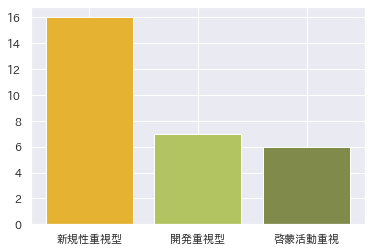

borda:


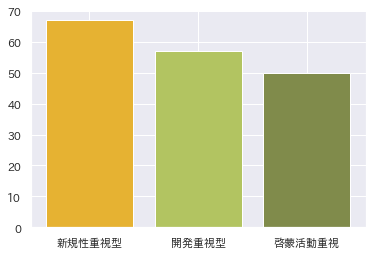

liquid:


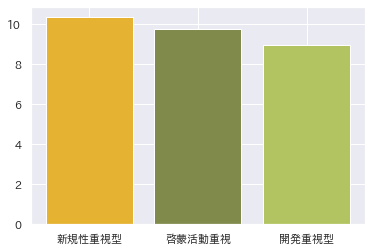

topic: Q2. 人口分布
fptp(多数決):


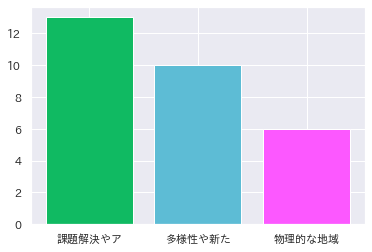

borda:


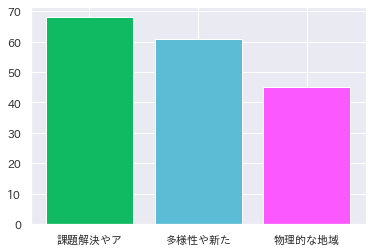

liquid:


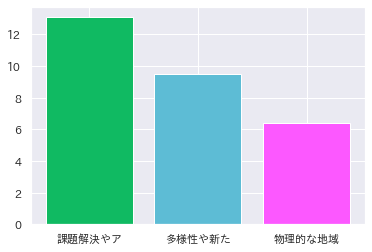

topic: Q1. 基本活動方針
fptp(多数決):


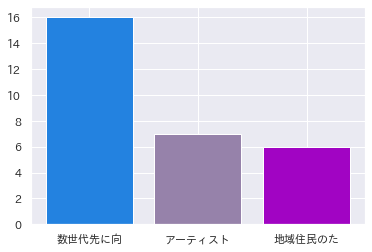

borda:


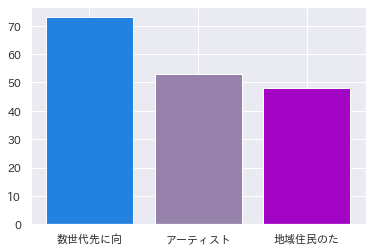

liquid:


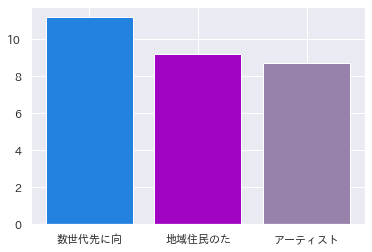

In [30]:
import altair as alt

for (id, result) in raw_results.items():
  print(f'topic: {new_topic_data[id]["title"]}')
  print(f'fptp(多数決):')
  (p, score, color) = zip(*[[policy_lookup[f[0]], f[1], f'#{f[0][:6]}'] for f in result['fptp'][1]])
  fptp_df = pd.DataFrame({'policy':p, 'score':score, 'color':color})
  pl.bar([p[:6] for p in fptp_df.policy], fptp_df.score, color=fptp_df.color)
  pl.show()

  print(f'borda:') 
  (p, score, color) = zip(*[[policy_lookup[b[0]], b[1], f'#{b[0][:6]}'] for b in result['borda'][1]])
  borda_df = pd.DataFrame({'policy':p, 'score':score, 'color': color})
  pl.bar([p[:6] for p in borda_df.policy], borda_df.score, color= borda_df.color)
  pl.show()

  print(f'liquid:')
  liquid = result['liquid'][0]
  (p, score, color) = zip(*sorted([[policy_lookup[l[0]], l[1], f'#{l[0][:6]}']  for l in liquid.items()], key=lambda x: x[1], reverse=True))
  liquid_df = pd.DataFrame({'policy':p, 'score':score, 'color':color})
  pl.bar([p[:6] for p in liquid_df.policy], liquid_df.score, color=liquid_df.color)
  pl.show()

  

まとめ：
三問とも回答した、29人の中で集計すると、多数決・ボルダ・リキッドデモクラシーの中で、もっとも票を集めた政策に齟齬はなかった。Q1.基本活動方針は「数世代先に向けた都市」 Q2.人口分布は「課題解決やアイディアを重視」Q3.予算は「新規制重視」となった。
